# Model Selection

## Import Libraries

In [384]:
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [104]:
db_conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = '',
    database = 'Store_Sales_db'
)

cursor = db_conn.cursor(buffered=True)
print('Database connected')

Database connected


## Loading Data From Database

In [108]:
# load dataframes
cursor.execute('SELECT * FROM oil')
oil = pd.DataFrame(cursor.fetchall(), 
                   columns=['date', 'dcoilwtico', 'year'])

In [110]:
oil

,date,dcoilwtico,year
0,2013-01-01,97.98,2013
1,2013-01-02,93.14,2013
2,2013-01-03,92.97,2013
3,2013-01-04,93.12,2013
4,2013-01-07,93.20,2013
...,...,...,...
1213,2017-08-25,47.65,2017
1214,2017-08-28,46.40,2017
1215,2017-08-29,46.46,2017
1216,2017-08-30,45.96,2017


In [112]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
 2   year        1218 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.7 KB


In [123]:
# load dataframes
cursor.execute('SELECT * FROM holidays')
holidays = pd.DataFrame(cursor.fetchall(), 
                   columns=['date', 'type', 'locale', 'locale_name', 'description', 'transferred'])

In [125]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,0
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,0


In [127]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 16.5+ KB


In [131]:
# load dataframes
cursor.execute('SELECT * FROM stores')
stores = pd.DataFrame(cursor.fetchall(), 
                   columns=['store_nbr', 'city', 'state', 'type', 'cluster'])

In [133]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [135]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [137]:
# load dataframes
cursor.execute('SELECT * FROM transactions')
transactions = pd.DataFrame(cursor.fetchall(), 
                   columns=['date', 'store_nbr', 'transactions'])

In [139]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [141]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [143]:
# load dataframes
cursor.execute('SELECT * FROM test')
test = pd.DataFrame(cursor.fetchall(), 
                   columns=['id', 'date', 'store_nbr', 'family', 'onpromotion'])

In [145]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [147]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [149]:
# load dataframes
cursor.execute('SELECT * FROM training_5')
training = pd.DataFrame(cursor.fetchall(), 
                   columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'])

In [150]:
training

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.730,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [153]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


## Model Training

### Data Perparing for training

In [170]:
query = """
SELECT a.*, b.dcoilwtico 
FROM training_5 a
LEFT JOIN 
oil b on a.date = b.date
"""
cursor.execute(query)

In [171]:
traing_set = pd.DataFrame(cursor.fetchall(), 
                   columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'oil_price'])

In [172]:
traing_set

,id,date,store_nbr,family,sales,onpromotion,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,97.98
1,1,2013-01-01,1,BABY CARE,0.000,0,97.98
2,2,2013-01-01,1,BEAUTY,0.000,0,97.98
3,3,2013-01-01,1,BEVERAGES,0.000,0,97.98
4,4,2013-01-01,1,BOOKS,0.000,0,97.98
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.730,148,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


In [179]:
traing_set[traing_set.oil_price.isna()]

,id,date,store_nbr,family,sales,onpromotion,oil_price
7128,7128,2013-01-05,1,AUTOMOTIVE,5.000,0,NaN
7129,7129,2013-01-05,1,BABY CARE,0.000,0,NaN
7130,7130,2013-01-05,1,BEAUTY,3.000,0,NaN
7131,7131,2013-01-05,1,BEVERAGES,1160.000,0,NaN
7132,7132,2013-01-05,1,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
2997319,2997319,2017-08-13,9,POULTRY,412.458,0,NaN
2997320,2997320,2017-08-13,9,PREPARED FOODS,105.169,1,NaN
2997321,2997321,2017-08-13,9,PRODUCE,1693.610,7,NaN
2997322,2997322,2017-08-13,9,SCHOOL AND OFFICE SUPPLIES,200.000,8,NaN


In [191]:
traing_set['year'] = traing_set['date'].dt.year
traing_set['month'] = traing_set['date'].dt.month
traing_set

,id,date,store_nbr,family,sales,onpromotion,oil_price,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,97.98,2013,1
1,1,2013-01-01,1,BABY CARE,0.000,0,97.98,2013,1
2,2,2013-01-01,1,BEAUTY,0.000,0,97.98,2013,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,97.98,2013,1
4,4,2013-01-01,1,BOOKS,0.000,0,97.98,2013,1
...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,2017,8
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,2017,8
3000885,3000885,2017-08-15,9,PRODUCE,2419.730,148,47.57,2017,8
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,2017,8


In [201]:
oil_month_means = traing_set.groupby(['year', 'month'])['oil_price'].mean()
oil_month_means

year  month
2013  1         95.036957
      2         95.442500
      3         93.178571
      4         92.021364
      5         94.660435
      6         95.772500
      7        104.380000
      8        106.572727
      9        105.893810
      10       100.538261
      11        94.060000
      12        97.625238
2014  1         94.491304
      2        100.435000
      3        100.803810
      4        101.664545
      5        101.767727
      6        105.794286
      7        103.135652
      8         96.536190
      9         93.210000
      10        84.396957
      11        76.658500
      12        59.290455
2015  1         47.350000
      2         50.488000
      3         47.823636
      4         54.189545
      5         58.760000
      6         59.819545
      7         50.803478
      8         42.867619
      9         45.624091
      10        46.223636
      11        42.739524
      12        37.188636
2016  1         32.788571
      2         30.940476


In [211]:
oil_month_means[2013][1]

95.03695652173913

In [261]:
# handling 2013
traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][1])
traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][2])
traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][3])
traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][4])
traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][5])
traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][6])
traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][7])
traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][8])
traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][9])
traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][10])
traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][11])
traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2013), 'oil_price'] = traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2013), 'oil_price'].fillna(oil_month_means[2013][12])

In [263]:
# checking null values
traing_set.loc[(traing_set['year'] == 2013), 'oil_price'].isna().sum()

0

In [269]:
# handling 2014
traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][1])
traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][2])
traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][3])
traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][4])
traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][5])
traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][6])
traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][7])
traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][8])
traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][9])
traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][10])
traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][11])
traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2014), 'oil_price'] = traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2014), 'oil_price'].fillna(oil_month_means[2014][12])

In [271]:
# checking null values
traing_set.loc[(traing_set['year'] == 2014), 'oil_price'].isna().sum()

0

In [275]:
# handling 2015
traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][1])
traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][2])
traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][3])
traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][4])
traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][5])
traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][6])
traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][7])
traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][8])
traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][9])
traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][10])
traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][11])
traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2015), 'oil_price'] = traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2015), 'oil_price'].fillna(oil_month_means[2015][12])

In [277]:
# checking null values
traing_set.loc[(traing_set['year'] == 2015), 'oil_price'].isna().sum()

0

In [281]:
# Handling 2016
traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][1])
traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][2])
traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][3])
traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][4])
traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][5])
traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][6])
traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][7])
traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][8])
traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 9) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][9])
traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 10) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][10])
traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 11) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][11])
traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2016), 'oil_price'] = traing_set.loc[(traing_set['month'] == 12) & (traing_set['year'] == 2016), 'oil_price'].fillna(oil_month_means[2016][12])

In [283]:
# checking null values
traing_set.loc[(traing_set['year'] == 2016), 'oil_price'].isna().sum()

0

In [289]:
# Handling 2017
traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 1) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][1])
traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 2) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][2])
traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 3) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][3])
traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 4) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][4])
traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 5) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][5])
traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 6) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][6])
traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 7) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][7])
traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2017), 'oil_price'] = traing_set.loc[(traing_set['month'] == 8) & (traing_set['year'] == 2017), 'oil_price'].fillna(oil_month_means[2017][8])

In [291]:
# checking null values
traing_set.loc[(traing_set['year'] == 2017), 'oil_price'].isna().sum()

0

In [295]:
traing_set['oil_price'].isna().sum()

0

In [301]:
traing_set.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
oil_price      0
year           0
month          0
dtype: int64

In [333]:
traing_set.describe()

,id,date,store_nbr,sales,onpromotion,oil_price,year,month
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00,6.787416e+01,2.014838e+03,6.207838e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,2.013000e+03,1.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.639500e+01,2.014000e+03,3.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,5.324825e+01,2.015000e+03,6.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,9.551000e+01,2.016000e+03,9.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.106200e+02,2.017000e+03,1.200000e+01
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01,2.558669e+01,1.345518e+00,3.385668e+00


### Store 1 AUTOMOTIVE Family data

In [331]:
auto_store1 = traing_set[(traing_set['family'] == 'AUTOMOTIVE') & (traing_set['store_nbr'] == 1)]
auto_store1 = auto_store1.drop(['id', 'date', 'store_nbr', 'family', 'year', 'month'], axis=1)
auto_store1

,sales,onpromotion,oil_price
0,0.0,0,97.980000
1782,2.0,0,93.140000
3564,3.0,0,92.970000
5346,3.0,0,93.120000
7128,5.0,0,95.036957
...,...,...,...
2991978,1.0,0,48.810000
2993760,6.0,0,48.902727
2995542,1.0,0,48.902727
2997324,1.0,0,47.590000


### Exp. 1: RNN 

In [342]:
auto_store1.values[0]

array([ 0.  ,  0.  , 97.98])

In [344]:
# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-(seq_length)):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [354]:
# Define sequence length
SEQ_LENGTH = 7  # Using past 5 days to predict the next day

X, y = create_sequences( auto_store1.values, SEQ_LENGTH)

In [356]:
# Split into training and testing sets (80-20 split)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [380]:
def build_simple_rnn(input_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(128, activation='tanh')(inputs)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
simple_rnn = build_simple_rnn((7,3))
simple_rnn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 7, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 128)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

In [388]:
# Train the model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=100
)
history_rnn_auto_store1 = simple_rnn.fit(X_train, y_train, epochs=1000, batch_size=32,
                             validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1534.4553 - val_loss: 347.5380
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1554.1652 - val_loss: 347.2801
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1486.0543 - val_loss: 347.3782
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1500.4805 - val_loss: 347.3457
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1512.8440 - val_loss: 347.4312
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1489.6869 - val_loss: 347.2165
Epoch 7/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1509.5344 - val_loss: 347.2567
Epoch 8/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1524.6042 - val_loss: 347.1612
Epoch 9/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1540.2784 - val_loss: 347.1766
Epoch 10/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1554.4198 - val_loss: 347.1765
Epoch 11/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1508.0717 - val_loss: 347.19

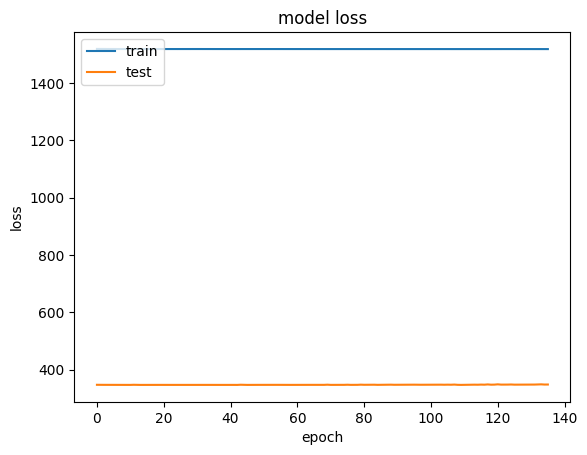

In [390]:
plt.plot(history_rnn_auto_store1.history['loss'])
plt.plot(history_rnn_auto_store1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [315]:
traing_set['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)